In [62]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
from torchvision.transforms import functional as TF
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, Image as IPImage

from wiring_efficiency_utils import *
from neuralsheet import *
from map_plotting import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Example usage
crop_size = 65 # Crop size (NxN)
batch_size = 64  # Number of crops to load at once
num_workers = 4  # Number of threads for data loading
root_dir = './input_stimuli'  # Path to your image folder
device = 'cuda'  # Assuming CUDA is available and desired
M = 56  # Neural sheet dimensions
std_exc = 0.25 # Standard deviation for excitation Gaussian
std_rfs = 5

dataloader = create_dataloader(root_dir, crop_size, batch_size, num_workers)
model = NeuralSheet(M, crop_size, std_exc, std_rfs, device=device).to(device)
rf_grids = get_grids(crop_size, crop_size, model.rf_size, M, device=device)

/home/nicolamendini/.local/lib/python3.10/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [3]:
lr = 1e-3
model.homeo_lr = 1e-3
beta = 1 - 6e-5
#network = init_nn(M, crop_size - model.rf_size + 1)
#network = init_nn(M, crop_size)
avg_loss = 0
avg_se = 0
avg_loss_std = 0
loss_beta = 1e-2

In [340]:
# Looping over the DataLoader

model.homeo_lr = lr
trials = 15
trialvar = np.sqrt(np.linspace(0.45, 2.2, trials))
sizesvar = np.round(np.sqrt(np.linspace(400, 3600, 4))).astype(int)
sizesvar = [20, 30, 50]
sizes = len(sizesvar)
#noise_lvls = sizes
#noise = np.linspace(0, 0.2, noise_lvls)
print(trialvar, sizesvar)
epochs = 2
reco_tracker = torch.zeros((sizes, trials, len(dataloader)))
se_tracker = torch.zeros((sizes, trials))
map_tracker = torch.zeros((sizes, trials, sizesvar[-1], sizesvar[-1]))
spectrum_tracker = torch.zeros((sizes, trials, sizesvar[-1], sizesvar[-1]))
peak_tracker = torch.zeros((sizes, trials))

tuning_curve_tracker = torch.zeros((sizes, trials, 30))
n_samples = 4
comp_tracker = torch.zeros((sizes, trials, n_samples*sizesvar[-1], n_samples*sizesvar[-1]))
se_pca_tracker = torch.zeros((sizes, trials))

code_tracker = []

for s in range(sizes):
    for t in range(trials):
        
        model = NeuralSheet(sizesvar[s], crop_size, trialvar[t], std_rfs, device=device).to(device)
        rf_grids = get_grids(crop_size, crop_size, model.rf_size, sizesvar[s], device=device)
        lr = 1e-3
        model.homeo_lr = 1e-3
        network = init_nn(sizesvar[s], crop_size - model.rf_size + 1)
        #network = init_nn(sizesvar[s], crop_size)
        avg_loss = 0
        code_tracker = []

        for e in range(epochs):

            batch_progress = tqdm(dataloader, leave=False)
            for b_idx, batch in enumerate(batch_progress):

                batch_responses = []
                batch_inputs = []
                batch = batch.to('cuda')  # Transfer the entire batch to GPU

                for image in batch:

                    image = image[0:1][None].flip(1)

                    if image.mean()>0.15:

                        lr *= beta
                        lr = lr if lr>1e-4 else 1e-4 
                        model.hebbian_lr = lr

                        model.homeo_lr *= beta
                        model.homeo_lr = model.homeo_lr if model.homeo_lr>1e-4 else 1e-4 

                        model(image, rf_grids)
                        model.hebbian_step()

                        batch_responses.append(model.current_response.clone())
                        batch_inputs.append(model.current_input.clone())
                        
                        code_tracker.append(model.current_response.clone())
                        #c = model.rf_size // 2
                        #code_tracker.append(image[:,:,c:-c,c:-c])

                batch_responses = torch.cat(batch_responses, dim=0)
                batch_inputs = torch.cat(batch_inputs, dim=0)

                reco_input = network['activ'](network['model'](batch_responses))

                c = model.rf_size // 2
                targets = batch_inputs[:,0,c:-c,c:-c][:,None]
                loss, loss_std = nn_loss(network, targets, reco_input)
                
                sim = cosim(targets.detach().cpu(), reco_input.detach().cpu(), True)
                sim = (sim - 0.6) / 0.4
                reco_tracker[s, t, b_idx] = sim
                                
                #se_mean = get_spectral_entropy(targets)       
                avg_loss = (1-loss_beta)*avg_loss + loss_beta*sim
                
                network['optim'].zero_grad()
                loss.backward()
                network['optim'].step()

                mean_activation = model.l4_mean_activations.mean()
                mean_std = model.l4_mean_activations.std() / model.homeo_target
                batch_progress.set_description('M:{:.3f}, STD:{:.3f}, BCE:{:.3f}, LR:{:.5f}'.format(
                    mean_activation, 
                    mean_std, 
                    avg_loss,
                    lr
                ))

                                
        ori_map, phase_map, mean_tc = get_orientations(model.afferent_weights, gabor_size=model.rf_size)
        ori_map = ori_map.view(sizesvar[s], sizesvar[s]).cpu()
        
        eff_dims, spectrum, peak = get_effective_dims(code_tracker)
        eff_dims_pca, samp_components = get_pca_dimensions(code_tracker, n_samples)
                           
        tuning_curve_tracker[s, t] = mean_tc
        se_tracker[s, t] = eff_dims
        se_pca_tracker[s, t] = eff_dims_pca
        
        comp_size = n_samples * sizesvar[s]
        comp_tracker[s, t, :comp_size, :comp_size] = samp_components
        
        print('Reco-SE-SEPCA so far: ', avg_loss, eff_dims, eff_dims_pca)
                
        map_tracker[s, t,:sizesvar[s],:sizesvar[s]] = ori_map
        spectrum_tracker[s,t,:sizesvar[s],:sizesvar[s]] = spectrum.cpu()
        peak_tracker[s,t] = peak.cpu()
        
        
data = {
    'reco_tracker' : reco_tracker,
    'se_tracker' : se_tracker,
    'map_tracker' : map_tracker,
    'spectrum_tracker': spectrum_tracker,
    'peak_tracker': peak_tracker,
    'comp_tracker': comp_tracker,
    'se_pca_tracker': se_pca_tracker,
    'tc_tracker' : tuning_curve_tracker,
    'trialvar': trialvar,
    'sizesvar': sizesvar
}

torch.save(data, 'data.pt')

[0.67082039 0.75828754 0.83666003 0.90829511 0.97467943 1.03682207
 1.09544512 1.15108644 1.20415946 1.25499004 1.30384048 1.35092561
 1.396424   1.44048603 1.4832397 ] [20, 30, 50]


KeyboardInterrupt: 

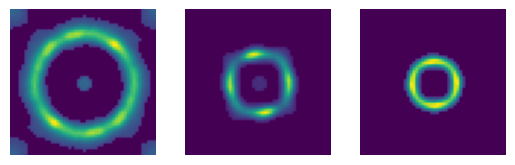

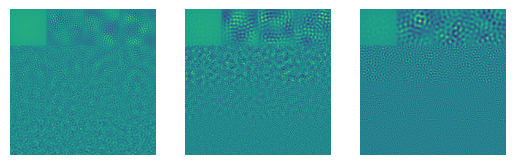

In [345]:
make_compx_plots(data)

Net Afferent Max: 0.344, Net Afferent Min: 0.204
Mean Act Max: 0.000, Mean Act Min: 0.000
Thresholds Max: 0.000, Thresholds Min: 0.000
L4 Thresholds Max: 0.314, L4 Thresholds Min: 0.226
Mean thresholds: 0.000 and mean OFF strength 1.000
Mean pos afferent Mean: 0.000 and aff strength 1.800
Mean current response: 0.089
L4 Strength: 3.058 strength: 1.000 aff strength: 1.800
Reco loss: 9.699%


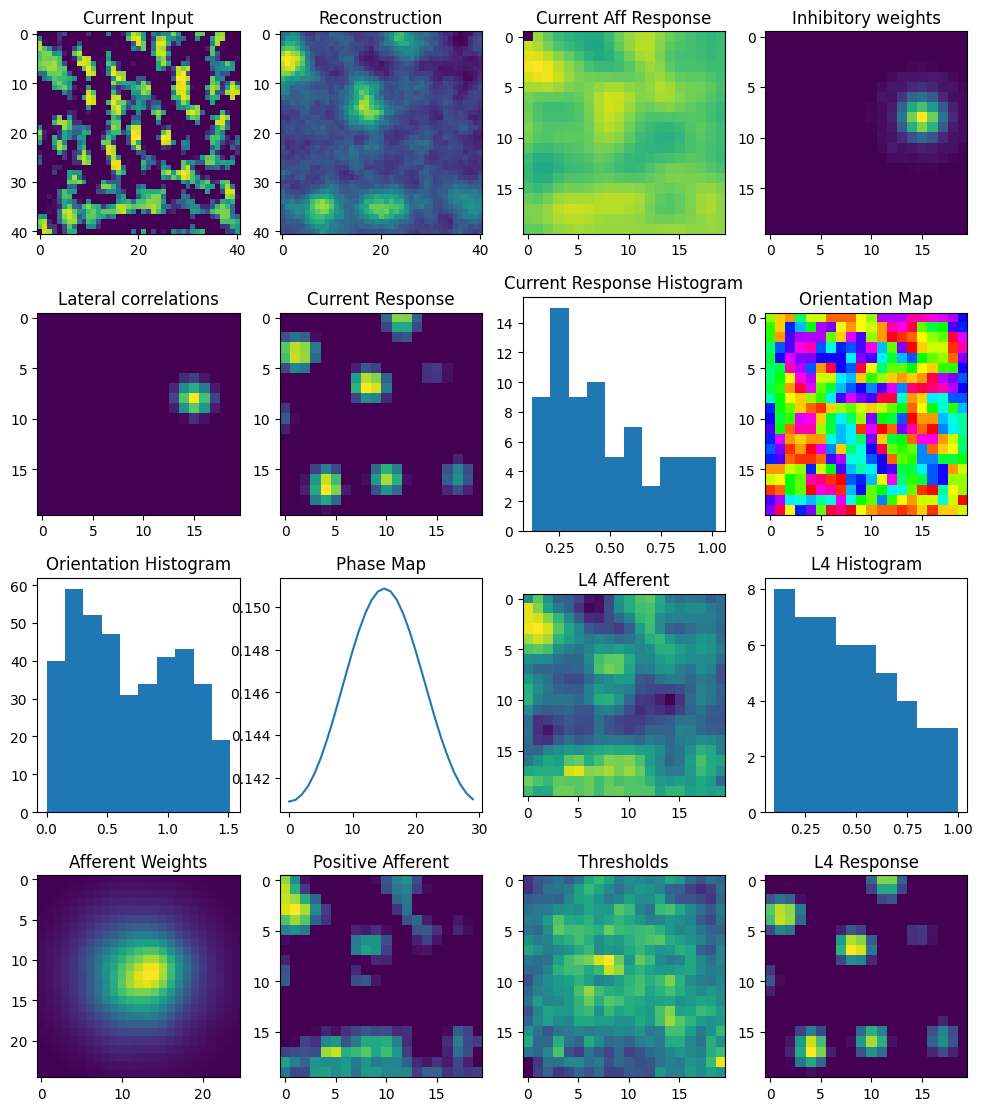

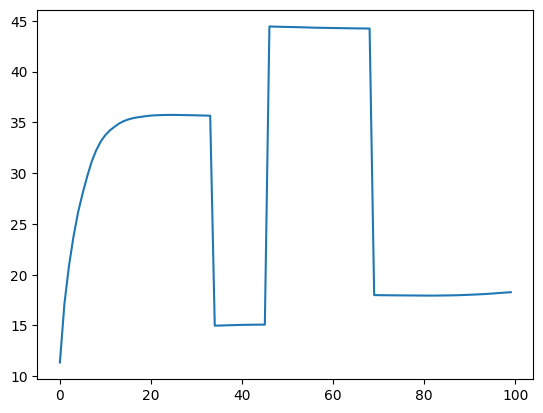

In [90]:
%matplotlib inline

random_sample = random.randint(0, model.afferent_weights.shape[0] - 1)
random_batch = random.randint(0, batch.shape[0] - 1)

model(batch[random_batch, 0:1][None].flip(1),rf_grids)
show_map(model, network, random_sample)
model.current_response.max()
array = model.response_tracker.cpu()[:,0]
array[:,0,0] = 1
anim = animate(array, model.iterations)
plt.plot(model.response_tracker[:model.iterations].sum([1,2,3]).cpu())
anim

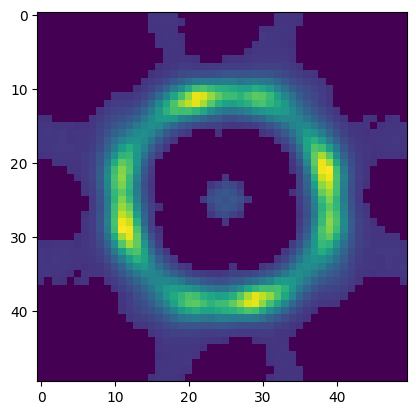

In [168]:
spectrum_tracker = data['spectrum_tracker']
plt.imshow(spectrum_tracker[-1, -10].cpu())

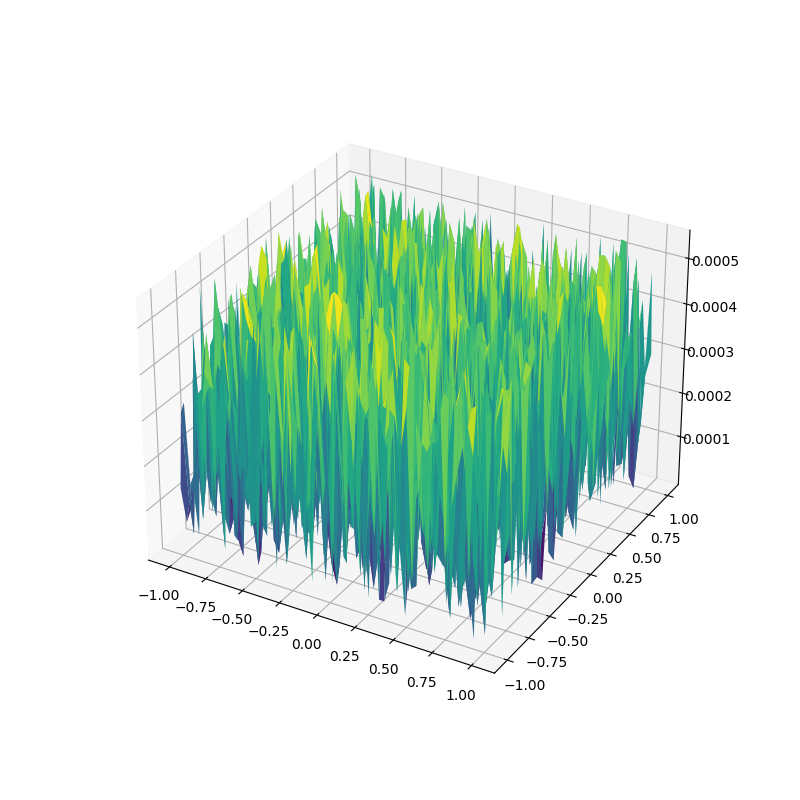

In [237]:
%matplotlib widget
sample = np.random.randint(0, model.sheet_size**2)
x = np.linspace(-1, 1, M)
y = np.linspace(-1, 1, M)
x, y = np.meshgrid(x, y)
z = model.lateral_correlations[sample,0].cpu() #* model.masks[sample,0].cpu()
#z = z*model.eq + model.untuned_inh[sample,0].cpu()*(1-model.eq)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')


ax.plot_surface(x, y, z, cmap='viridis', edgecolor='none', rstride=1, cstride=1, alpha=1)
plt.show()

<Figure size 640x480 with 0 Axes>

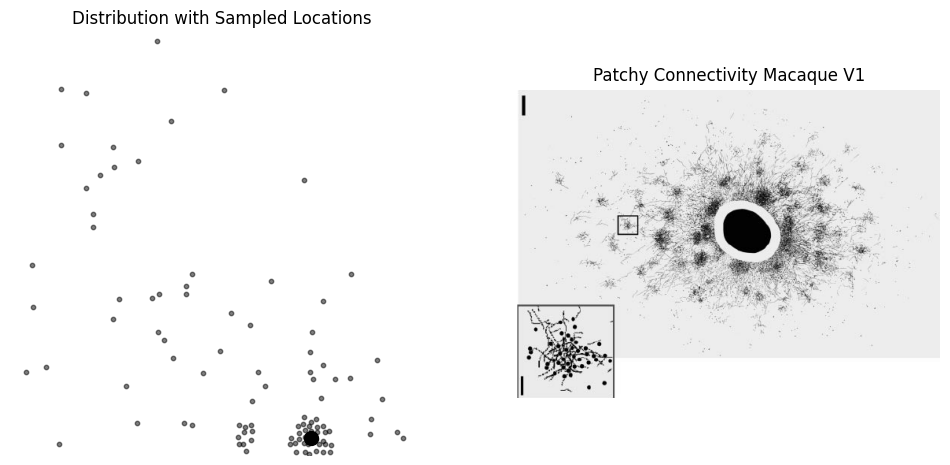

In [582]:
plt.clf()
%matplotlib inline

num_samples = 100   # Number of samples you want to draw
theta = 0

# Assuming model.sheet_size and M are defined elsewhere
# model.sheet_size = ...  
M = model.sheet_size

sample_idx = np.random.randint(0, model.sheet_size**2)
z = model.lateral_correlations[sample_idx, 0].cpu()

# Generate an example distribution (MxM)
# This could be your actual distribution, ensure it sums to 1 if it represents probabilities
distribution = torch.relu(z - theta)
distribution /= distribution.sum()

sample_and_plot(distribution, num_samples, sample_idx)

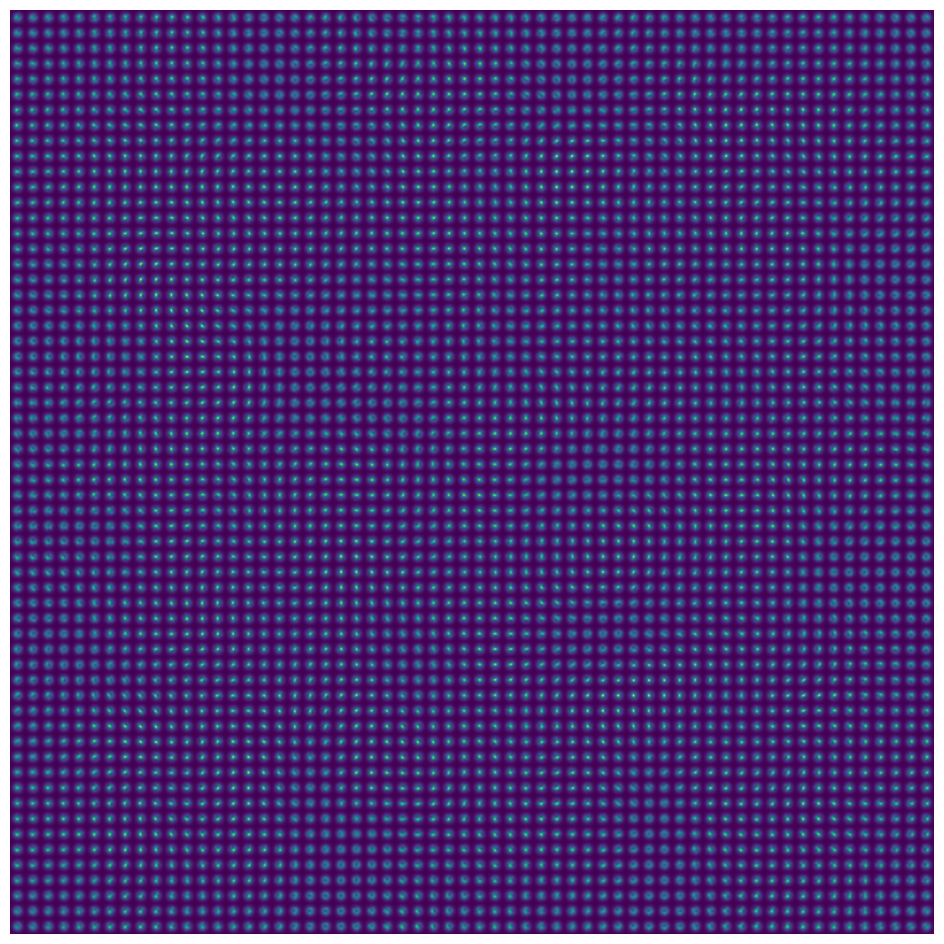

In [ ]:
%matplotlib inline
angles = model.afferent_weights.cpu()
angles = angles.view(60, 60, model.rf_size, model.rf_size)
angles = angles.permute(0,2,1,3).reshape(60*model.rf_size, 60*model.rf_size)
plt.figure(figsize=(12,12))
plt.axis('off')
plt.imshow(angles)

In [101]:
state = {

    'afferent' : model.afferent_weights,
    'lateral' : model.lateral_correlations
    
}

In [102]:
torch.save(state, 'state.pt')

In [4]:
state = torch.load('state.pt')
model.afferent_weights = state['afferent']
model.lateral_correlations = state['lateral']